# SARIMA/SARIMAX

In [1]:
# Import required modules
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import pmdarima as pm

from datetime import datetime
from matplotlib import pyplot as plt
from numpy import log
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import itertools
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series,maxlag = 52, autolag = None)
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)
# Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')
    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')
    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [3]:
# Read data 
data_features = pd.read_csv('dengue_features_train.csv')
data_labels = pd.read_csv('dengue_labels_train.csv')

## Data Pre-processing

In [4]:
# Combine data 
data = data_features.merge (data_labels)
data["week_start_date"] = pd.to_datetime(data["week_start_date"])

In [5]:
# Group data by city 
grouped = data.groupby(data_features.city)
# Separate data for San Juan, Puerto Rico ("SJ")
sj = grouped.get_group ("sj")
# Separate data for Iquitos, Peru ("IQ")  
iq = grouped.get_group ("iq")

In [6]:
# Drop week_start_date from SJ and IQ train features
sj = sj.drop(['city','year','weekofyear',],axis=1)
iq = iq.drop(['city','year','weekofyear',],axis=1)

In [7]:
# Fill NA values (Forward fill)
sj.fillna(method='ffill', inplace=True)
iq.fillna(method='ffill', inplace=True)

In [8]:
# Create data labels as separate dataframe
sj_labels = sj[['week_start_date', 'total_cases']]
sj_labels = sj_labels.set_index('week_start_date')

iq_labels = iq[['week_start_date', 'total_cases']]
iq_labels = iq_labels.set_index('week_start_date')

In [9]:
# Split the last 20% (188 rows) from SJ dataset to form the SJ test dataset
sj_train = sj[:-188].set_index(['week_start_date'])
sj_test = sj.tail(188).set_index(['week_start_date'])
sj_train_features = sj[:-188].drop('total_cases', axis = 1).set_index(['week_start_date'])
sj_test_features = sj.tail(188).drop('total_cases', axis = 1).set_index(['week_start_date'])
sj_train_labels = sj_labels[:-188]
sj_test_labels = sj_labels.tail(188)

# Split the last 20% (104 rows) from IQ dataset to form the IQ test dataset
iq_train = iq[:-104].set_index(['week_start_date'])
iq_test = iq.tail(104).set_index(['week_start_date'])
iq_train_features = iq[:-104].drop('total_cases', axis = 1).set_index(['week_start_date'])
iq_test_features = iq.tail(104).drop('total_cases', axis = 1).set_index(['week_start_date'])
iq_train_labels = iq_labels[:-104]
iq_test_labels = iq_labels.tail(104)

## Data Visualisation



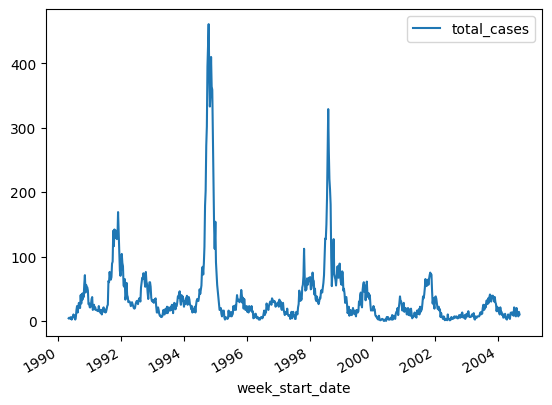

In [10]:
# Plot San Juan total_cases
sj_train_labels.plot()
plt.show()

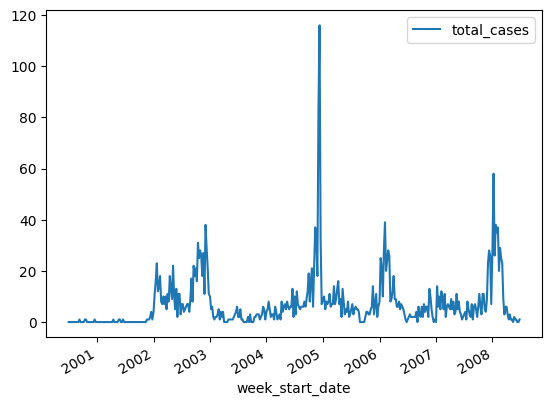

In [11]:
# Plot Iquitos total_cases
iq_train_labels.plot()
plt.show()

In [12]:
# Check distribution of train data labels 
print('San Juan')
print('mean: ', sj_train_labels.mean()[0])
print('var :', sj_train_labels.var()[0])

print('\nIquitos')
print('mean: ', iq_train_labels.mean()[0])
print('var :', iq_train_labels.var()[0])

San Juan
mean:  36.5668449197861
var : 3031.5176141285283

Iquitos
mean:  7.076923076923077
var : 111.06394810009267


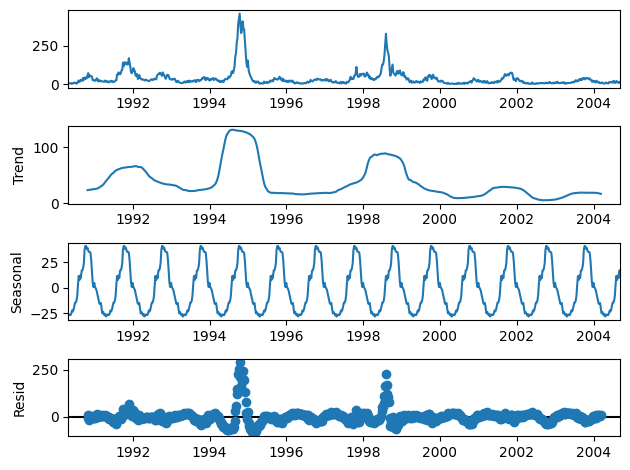

In [13]:
# Decompose SJ data  
result_sj = seasonal_decompose(sj_train_labels, period=52)
result_sj.plot()
plt.show()

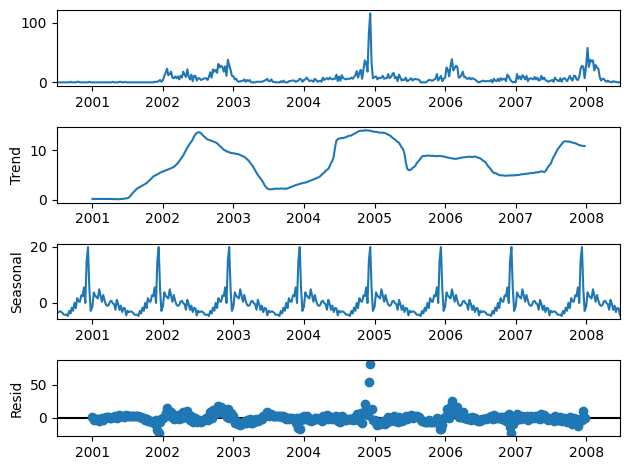

In [14]:
# Decompose IQ data  
result_iq = seasonal_decompose(iq_train_labels, period=52)
result_iq.plot()
plt.show()

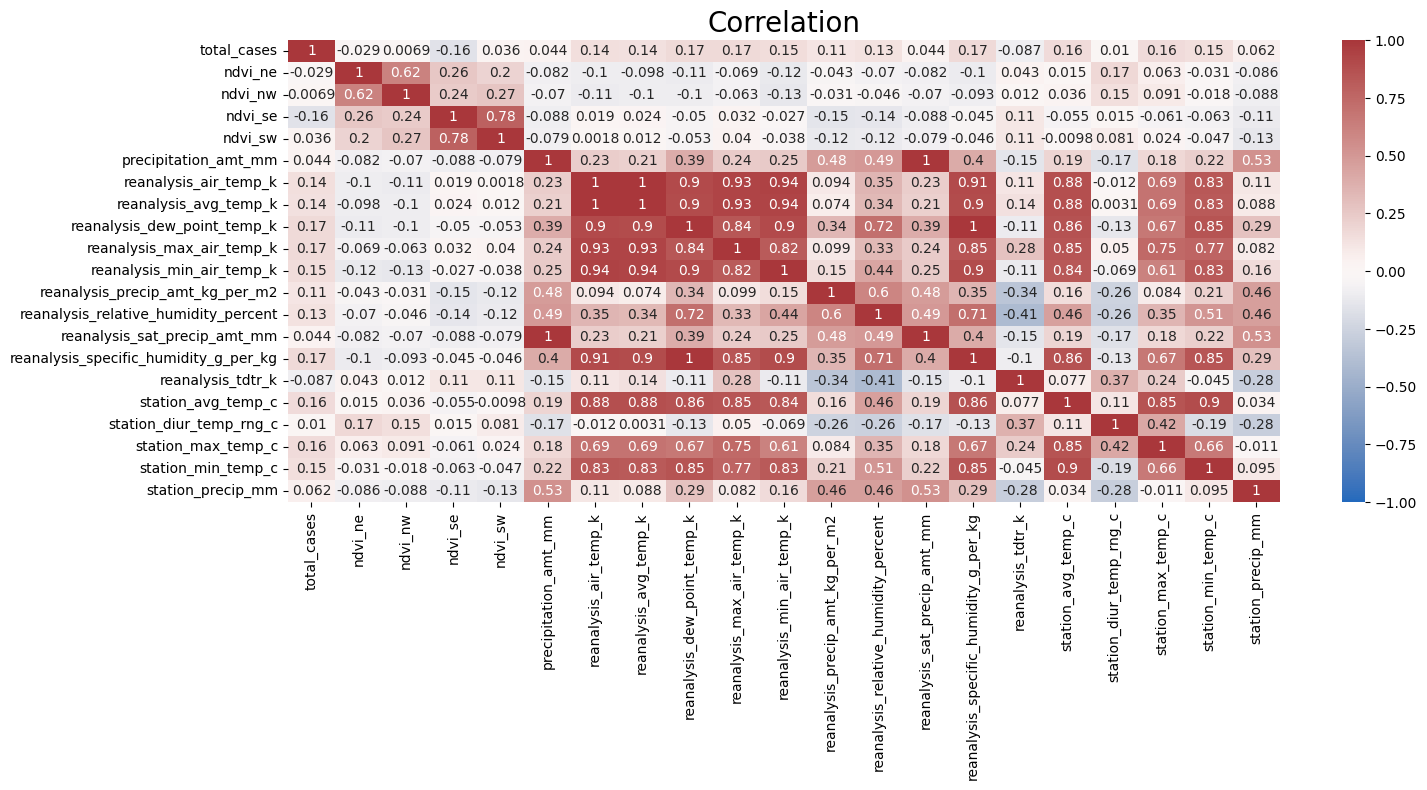

In [15]:
def plot_correlation(plot_df):
    display_order = ["total_cases", *plot_df.columns.drop("total_cases")]
    plot_df = plot_df[display_order]
    plt.figure(figsize=(16, 6))
    sns.heatmap(plot_df.corr(), vmin=-1, vmax=1, center=0, annot=True, cmap="vlag")
    plt.title("Correlation", fontsize=20)
    plt.show()


plot_correlation(sj_train)

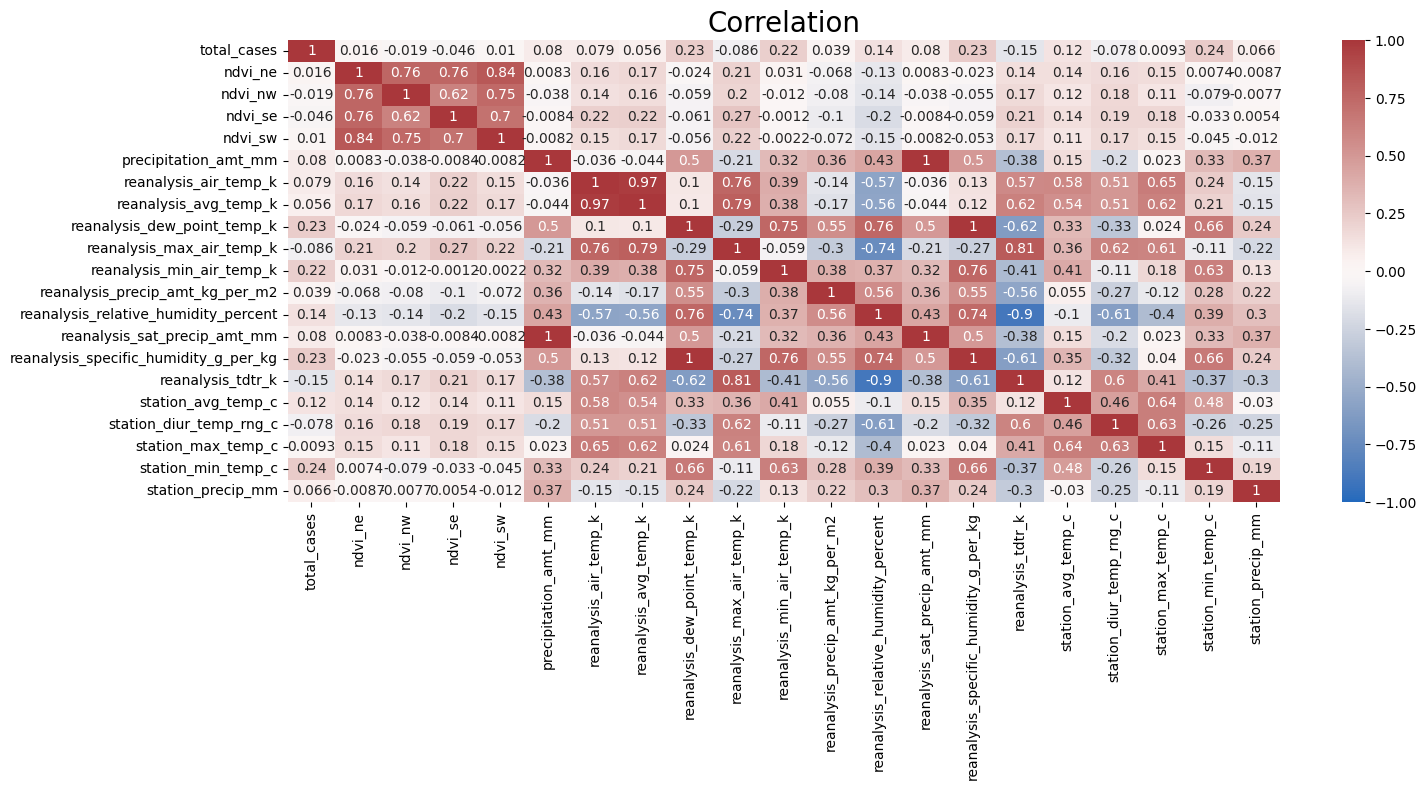

In [16]:
plot_correlation(iq_train)

### SARIMA

### SJ

In [17]:
sj_train_labels1 = sj_train_labels.copy()
sj_train_labels1.index = pd.DatetimeIndex(sj_train_labels1.index).to_period('W-SUN')
sj_test_labels1 = sj_test_labels.copy()
sj_test_labels1.index = pd.DatetimeIndex(sj_test_labels1.index).to_period('W-SUN')
sj_labels1 = sj_labels.copy()
sj_labels1.index = pd.DatetimeIndex(sj_labels1.index).to_period('W-SUN')

iq_train_labels1 = iq_train_labels.copy()
iq_train_labels1.index = pd.DatetimeIndex(iq_train_labels1.index).to_period('W-SUN')
iq_test_labels1 = iq_test_labels.copy()
iq_test_labels1.index = pd.DatetimeIndex(iq_test_labels1.index).to_period('W-SUN')
iq_labels1 = iq_labels.copy()
iq_labels1.index = pd.DatetimeIndex(iq_labels1.index).to_period('W-SUN')

In [18]:
adfuller_test(sj_train_labels1)

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.2324
 No. Lags Chosen       = 52
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0182. Rejecting Null Hypothesis.
 => Series is Stationary.


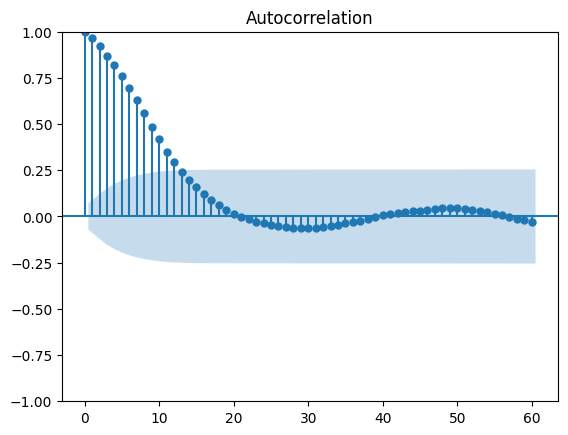

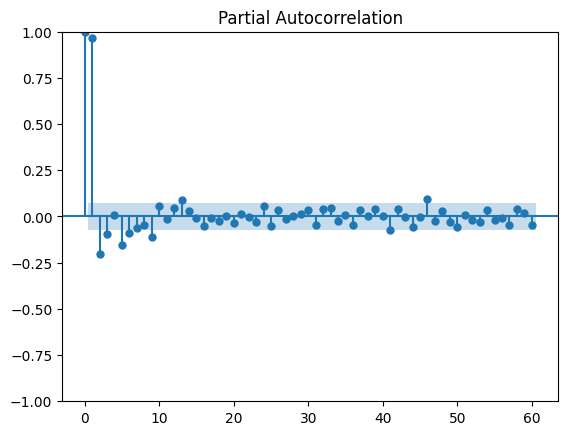

In [19]:
plot_acf(sj_train_labels1, lags = 60)
plt.show()
plot_pacf(sj_train_labels1, lags = 60)
plt.show()

In [20]:
sj_stepwise_fit = pm.auto_arima(sj_train_labels1, start_p=1, start_q=1, max_p=3, max_d=2,max_q=2,m=52,
                             start_P=0,start_Q=0,max_P=3, max_D=2,max_Q=2, seasonal=True, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise
sj_stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=6058.617, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=6082.107, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=6061.603, Time=3.31 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=6065.188, Time=2.48 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=6080.107, Time=0.03 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=6060.239, Time=3.33 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AIC=6060.276, Time=3.82 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=6.75 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=6063.861, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=6060.340, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[52] intercept   : AIC=6055.076, Time=0.18 sec
 ARIMA(2,1,1)(1,0,0)[52] intercept   : AIC=6056.651, Time=5.25 sec
 ARIMA(2,1,1)(0,0,1)[52] intercept   : AIC=6056.697, Time=5.29 sec
 ARIMA(2,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=8.63 sec
 ARIMA(2,1,0)(0,0,0)[52] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  748
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -3022.538
Date:                Tue, 25 Oct 2022   AIC                           6053.077
Time:                        19:16:36   BIC                           6071.541
Sample:                    05-06-1990   HQIC                          6060.193
                         - 09-12-2004                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6393      0.061    -10.447      0.000      -0.759      -0.519
ar.L2          0.2074      0.013     15.882      0.000       0.182       0.233
ma.L1          0.8147      0.065     12.505      0.000       0.687       0.942
sigma2       191.4248      4.235     45.202      0.000     183.125     199.725
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3448.48
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
#ARIMA(2, 1, 1)x(0, 0, 0, 52)
mod = sm.tsa.statespace.SARIMAX(sj_train_labels1,
                                order=(2, 1, 1),
                                seasonal_order=(0, 0, 0, 52))
results = mod.fit(method = 'powell')
print(results.summary().tables[1])

Optimization terminated successfully.
         Current function value: 4.042360
         Iterations: 1
         Function evaluations: 46
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3497      0.127     -2.755      0.006      -0.599      -0.101
ar.L2          0.1730      0.022      7.854      0.000       0.130       0.216
ma.L1          0.5210      0.131      3.967      0.000       0.264       0.778
sigma2       192.0176      4.214     45.571      0.000     183.759     200.276


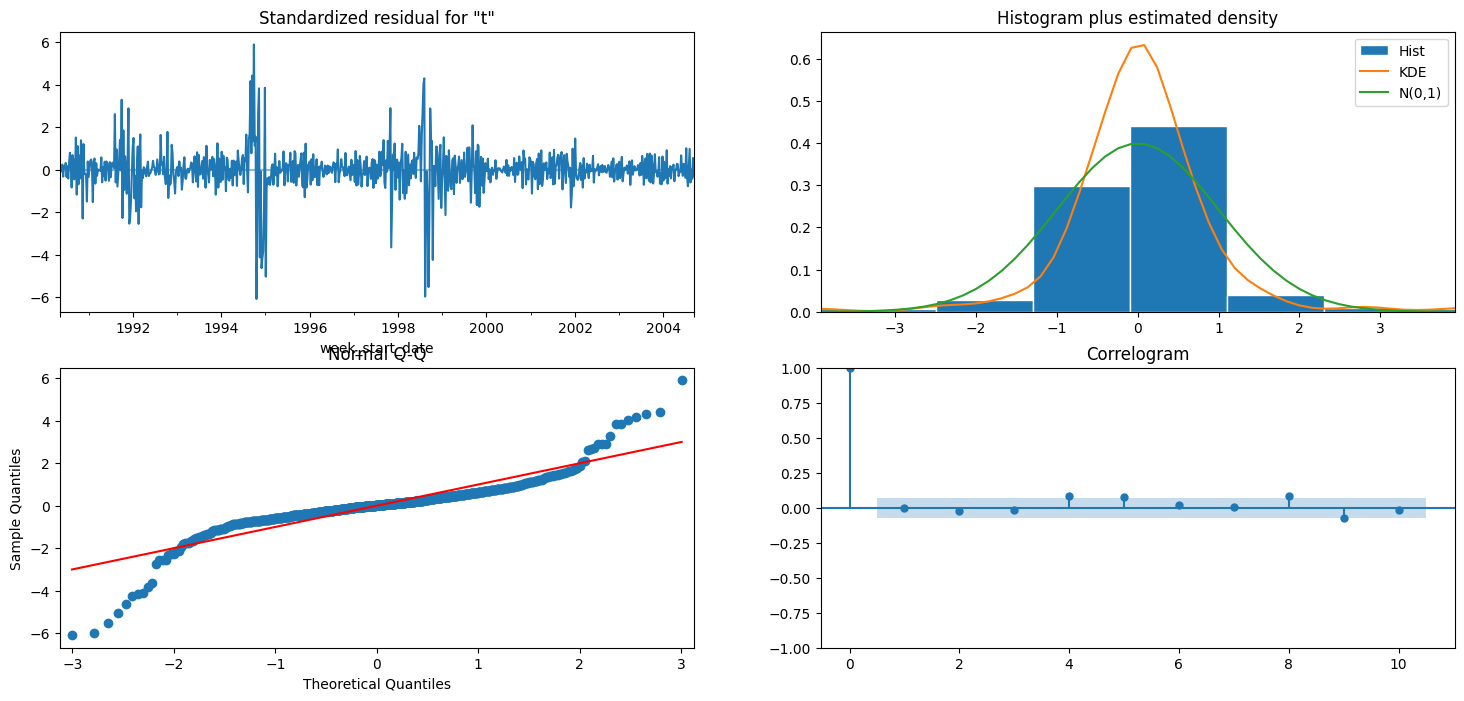

In [22]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

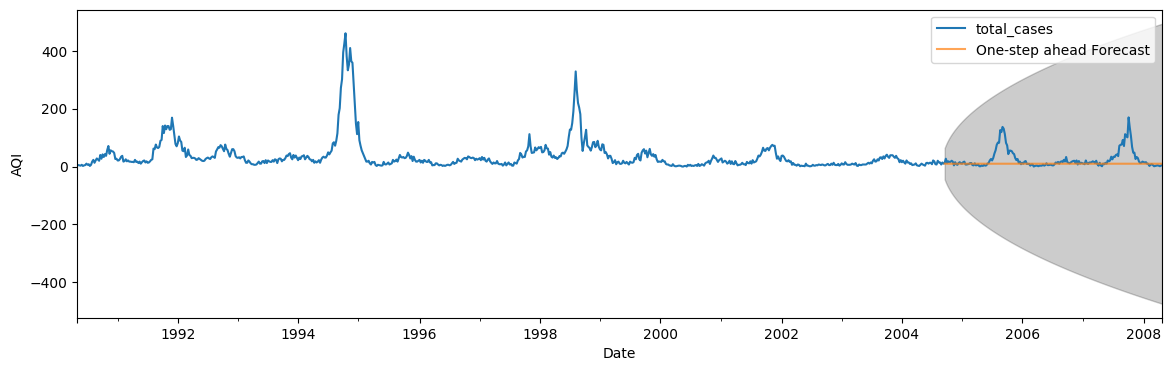

In [23]:
pred = results.get_prediction(start=pd.to_datetime('2004-09-16'), end = pd.to_datetime('2008-04-22'), dynamic=False)
pred_ci = pred.conf_int()
ax = sj_labels1.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('AQI')
plt.legend()
plt.show()

In [24]:
y_forecasted = pred.predicted_mean
y_forecasted = y_forecasted.values
y_truth = sj_test_labels1.values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))

The Mean Squared Error is 1195.94


### IQ

In [25]:
adfuller_test(iq_train_labels1)

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.0492
 No. Lags Chosen       = 52
 Critical value 1%     = -3.448
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0305. Rejecting Null Hypothesis.
 => Series is Stationary.


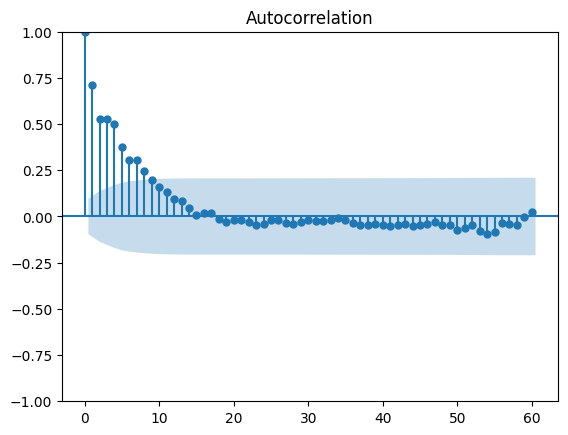

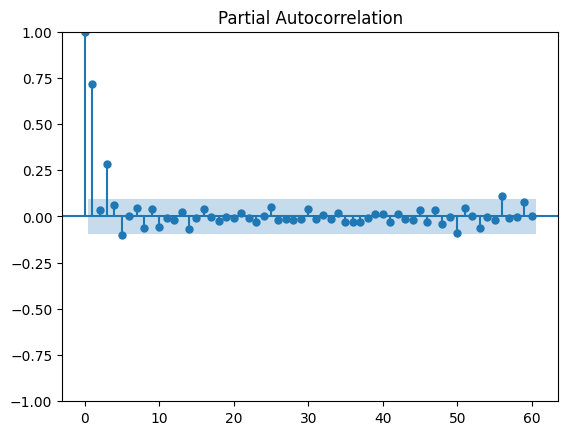

In [26]:
plot_acf(iq_train_labels1, lags = 60)
plt.show()
plot_pacf(iq_train_labels1, lags = 60)
plt.show()

In [28]:
iq_stepwise_fit = pm.auto_arima(iq_train_labels1, start_p=1, start_q=1, max_p=3, max_d=2,max_q=2,m=52,
                             start_P=0,start_Q=0,max_P=3, max_D=2, max_Q=2, seasonal=True, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise
iq_stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=2847.480, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2902.989, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2891.885, Time=1.42 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2868.774, Time=1.23 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2900.989, Time=0.02 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=2848.057, Time=2.17 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AIC=2848.413, Time=2.20 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=7.38 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2867.965, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=2892.495, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[52] intercept   : AIC=2831.248, Time=0.08 sec
 ARIMA(2,1,1)(1,0,0)[52] intercept   : AIC=2832.392, Time=2.54 sec
 ARIMA(2,1,1)(0,0,1)[52] intercept   : AIC=2832.589, Time=2.72 sec
 ARIMA(2,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=4.99 sec
 ARIMA(2,1,0)(0,0,0)[52] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  416
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -1410.175
Date:                Tue, 25 Oct 2022   AIC                           2828.350
Time:                        19:18:07   BIC                           2844.463
Sample:                    07-02-2000   HQIC                          2834.722
                         - 06-29-2008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2795      0.015    -18.651      0.000      -0.309      -0.250
ar.L2         -0.3946      0.012    -32.555      0.000      -0.418      -0.371
ar.L3         -0.1194      0.022     -5.326      0.000      -0.163      -0.075
sigma2        52.3144      1.119     46.761      0.000      50.122      54.507
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              8872.76
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                             1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
#ARIMA(3, 1, 0)x(0, 0, 0, 52)
mod = sm.tsa.statespace.SARIMAX(iq_train_labels1,
                                order=(3, 1, 0),
                                seasonal_order=(0, 0, 0, 52))
results = mod.fit(method = 'powell')
print(results.summary().tables[1])

Optimization terminated successfully.
         Current function value: 3.389844
         Iterations: 1
         Function evaluations: 48
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2791      0.015    -18.622      0.000      -0.308      -0.250
ar.L2         -0.3946      0.012    -32.555      0.000      -0.418      -0.371
ar.L3         -0.1194      0.022     -5.325      0.000      -0.163      -0.075
sigma2        52.3136      1.119     46.761      0.000      50.121      54.506


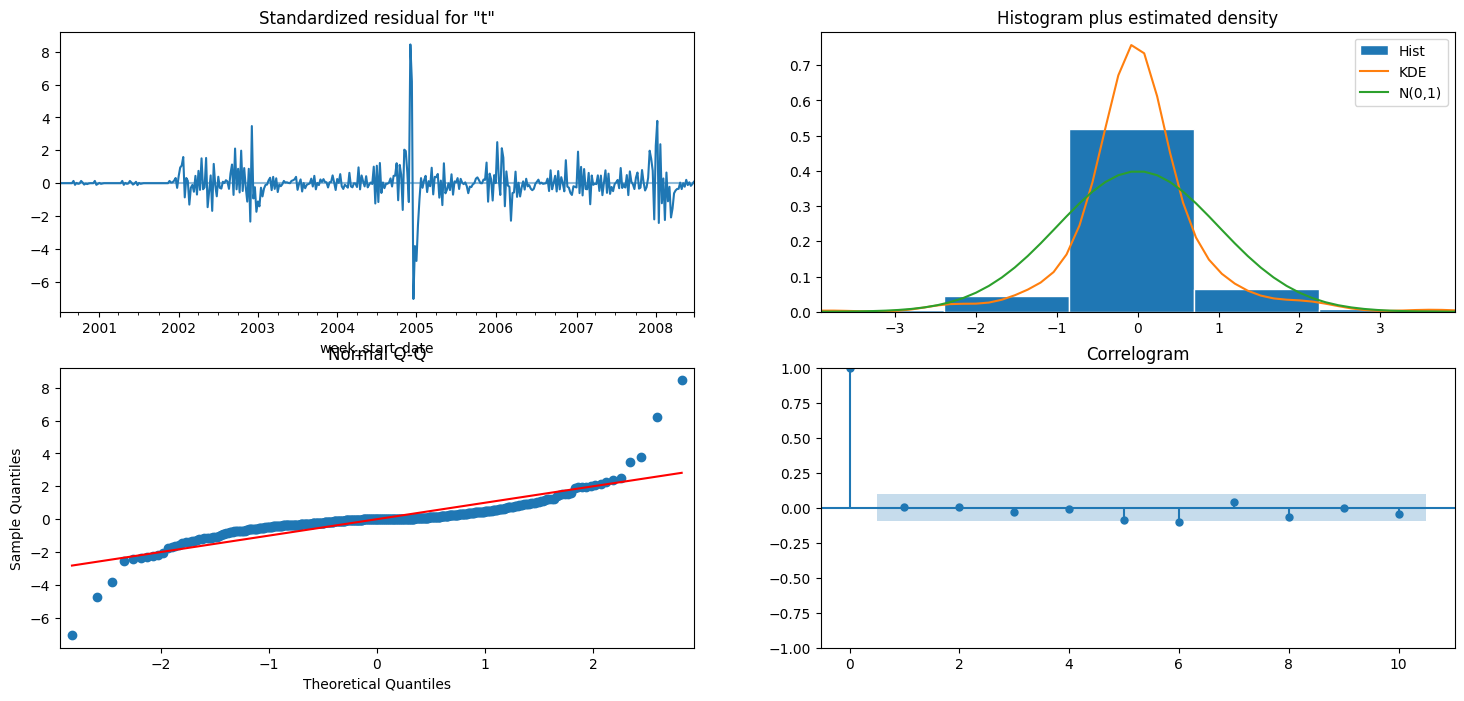

In [30]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

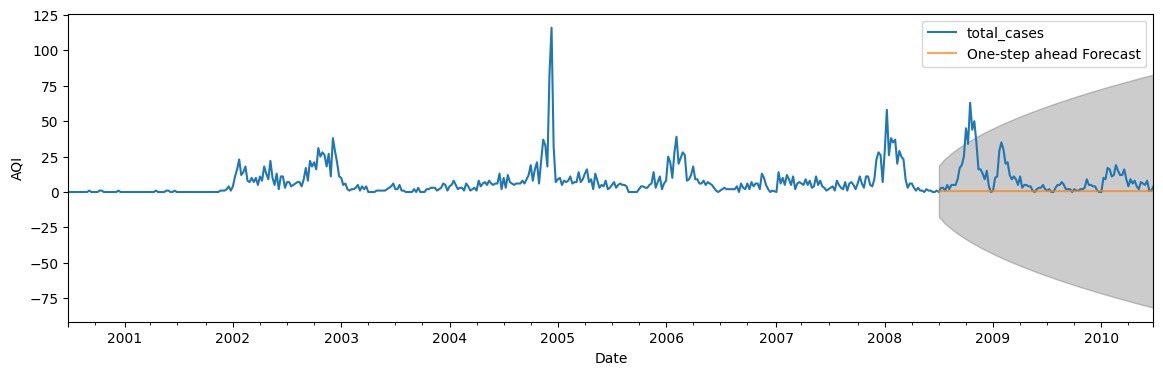

In [31]:
pred1 = results.get_prediction(start=pd.to_datetime('2008-07-01'), end = pd.to_datetime('2010-06-25'), dynamic=False)
pred_ci1 = pred1.conf_int()
ax = iq_labels1.plot(label='observed')
pred1.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci1.index,
                pred_ci1.iloc[:, 0],
                pred_ci1.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('AQI')
plt.legend()
plt.show()

In [32]:
y_forecasted1 = pred1.predicted_mean
y_forecasted1 = y_forecasted1.values
y_truth1 = iq_test_labels1.values
mse = ((y_forecasted1 - y_truth1) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))

The Mean Squared Error is 209.53


### SARIMAX 

### SJ

In [33]:
sj_train1 = sj_train.drop(columns = ["reanalysis_avg_temp_k","reanalysis_dew_point_temp_k","reanalysis_max_air_temp_k","reanalysis_min_air_temp_k","reanalysis_sat_precip_amt_mm","reanalysis_specific_humidity_g_per_kg"])
sj_test1 = sj_test.drop(columns = ["reanalysis_avg_temp_k","reanalysis_dew_point_temp_k","reanalysis_max_air_temp_k","reanalysis_min_air_temp_k","reanalysis_sat_precip_amt_mm","reanalysis_specific_humidity_g_per_kg"]) 
iq_train1 = iq_train.drop(columns = ["reanalysis_avg_temp_k","reanalysis_dew_point_temp_k","reanalysis_max_air_temp_k","reanalysis_min_air_temp_k","reanalysis_sat_precip_amt_mm","reanalysis_specific_humidity_g_per_kg"])
iq_test1 = iq_test.drop(columns = ["reanalysis_avg_temp_k","reanalysis_dew_point_temp_k","reanalysis_max_air_temp_k","reanalysis_min_air_temp_k","reanalysis_sat_precip_amt_mm","reanalysis_specific_humidity_g_per_kg"]) 

In [34]:
for name, column in sj_train1.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "ndvi_ne" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.4712
 No. Lags Chosen       = 52
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.1227. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ndvi_nw" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8609
 No. Lags Chosen       = 52
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0501. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ndvi_se" 
    -----------------------------------------------
 Null Hypothesis: Data ha

In [35]:
sj_train2 = sj_train1.diff().dropna() 
for name, column in sj_train2.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "ndvi_ne" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.0059
 No. Lags Chosen       = 52
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ndvi_nw" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.1466
 No. Lags Chosen       = 52
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ndvi_se" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  

In [36]:
x = sj_train2.values
#Standardise dataset
standard_scaler = StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
scaled_data = pd.DataFrame(x_scaled)
scaled_data.columns = sj_train2.columns

for name, column in scaled_data.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "ndvi_ne" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.0059
 No. Lags Chosen       = 52
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ndvi_nw" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.1466
 No. Lags Chosen       = 52
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ndvi_se" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  

In [37]:
sj_stepwise_fit1 = pm.auto_arima(sj_train2["total_cases"], start_p=1, start_q=1, max_p=3, max_d=2,max_q=2,m=52,
                             start_P=0,start_Q=0,max_P=3, max_D=2,max_Q=2, seasonal=True, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise
sj_stepwise_fit1.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=6058.617, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=6082.107, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=6061.603, Time=4.27 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=6065.188, Time=3.01 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=6080.107, Time=0.02 sec
 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=6060.239, Time=6.27 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=6060.276, Time=5.07 sec
 ARIMA(1,0,1)(1,0,1)[52] intercept   : AIC=inf, Time=8.58 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=6063.861, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=6060.340, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=6055.076, Time=0.25 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=6056.651, Time=7.49 sec
 ARIMA(2,0,1)(0,0,1)[52] intercept   : AIC=6056.697, Time=6.73 sec
 ARIMA(2,0,1)(1,0,1)[52] intercept   : AIC=inf, Time=13.51 sec
 ARIMA(2,0,0)(0,0,0)[52] int

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  747
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -3022.538
Date:                Tue, 25 Oct 2022   AIC                           6053.077
Time:                        19:19:28   BIC                           6071.541
Sample:                             0   HQIC                          6060.193
                                - 747                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6393      0.061    -10.447      0.000      -0.759      -0.519
ar.L2          0.2074      0.013     15.882      0.000       0.182       0.233
ma.L1          0.8147      0.065     12.505      0.000       0.687       0.942
sigma2       191.4248      4.235     45.202      0.000     183.125     199.725
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3448.48
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
sj_test2 = sj_test1.drop(columns=["total_cases"])
sj_test_labels2 = sj_test1["total_cases"]
sj_train3 = sj_train2.drop(columns=["total_cases"])
sj_train_labels2 = sj_train2["total_cases"]

forecast_index = pd.date_range('2004-09-16', '2008-04-22',freq="W")
driver_forecasts = pd.DataFrame(index=forecast_index, columns= sj_test2.columns)

date_index = pd.date_range('1990-05-06', '09-09-2004',freq="W")
row1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]
row2 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]
date1=datetime.strptime('25-12-1994 0:0:0','%d-%m-%Y %H:%M:%S')
date2=datetime.strptime('24-12-2000 0:0:0','%d-%m-%Y %H:%M:%S')
sj_train3.loc[date1,:] = row1
sj_train3.loc[date2,:] = row2
sj_train3 = sj_train3.sort_index()
sj_train3.index = date_index

In [39]:
for i in range(len(sj_test2.columns)):
                                            df_series = sj_train3
                                            series_features = pd.Series(df_series.iloc[:,i], index= df_series.index)

                                            stepwise_fit_features = pm.auto_arima(series_features, start_p=2, start_q=1, max_p=2, max_d=2,max_q=3,m=52,
                                                                         start_P=0,start_Q=0,max_P=1,max_D=2,max_Q=3, seasonal=True, trace=True,
                                                                         error_action='ignore',  # don't want to know if an order does not work
                                                                         suppress_warnings=True,  # don't want convergence warnings
                                                                         stepwise=True)  # set to stepwise

                                            SARIMA_Forecast_features = stepwise_fit_features.predict(n_periods= 188)
                                            #Add to driver forecast dataset
                                            driver_forecasts.iloc[:,i] = SARIMA_Forecast_features

driver_forecasts.head(5)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=-1513.363, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=-1215.017, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=-1321.739, Time=5.14 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=-1480.519, Time=8.41 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=-1217.017, Time=0.06 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=-1511.426, Time=18.03 sec
 ARIMA(2,0,1)(0,0,1)[52] intercept   : AIC=-1511.429, Time=16.59 sec
 ARIMA(2,0,1)(1,0,1)[52] intercept   : AIC=-1509.420, Time=16.22 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=-1515.361, Time=0.48 sec
 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=-1513.425, Time=12.14 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=-1513.428, Time=15.06 sec
 ARIMA(1,0,1)(1,0,1)[52] intercept   : AIC=-1511.420, Time=17.17 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=-1482.118, Time=0.50 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=-1323.610, Time=0.19 sec

 ARIMA(0,0,1)(0,0,1)[52]             : AIC=1169.587, Time=1.32 sec
 ARIMA(0,0,0)(1,0,0)[52]             : AIC=1248.917, Time=0.62 sec
 ARIMA(1,0,1)(1,0,0)[52]             : AIC=1169.921, Time=1.47 sec
 ARIMA(1,0,0)(1,0,0)[52]             : AIC=1179.886, Time=0.81 sec

Best model:  ARIMA(0,0,1)(1,0,0)[52]          
Total fit time: 54.446 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=7771.187, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=7640.423, Time=5.71 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=7471.054, Time=4.56 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=7769.187, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=7475.082, Time=0.14 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=7472.880, Time=10.06 sec
 ARIMA(0,0,1)(1,0,0)[52] intercept   : AIC=7470.918, Time=3.79 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=7773.042, Time=2.16 sec
 ARIMA(1,0,

 ARIMA(2,0,0)(1,0,0)[52]             : AIC=2382.166, Time=0.86 sec
 ARIMA(1,0,0)(1,0,0)[52]             : AIC=2424.446, Time=1.06 sec

Best model:  ARIMA(2,0,1)(1,0,0)[52]          
Total fit time: 68.443 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=1970.249, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2196.623, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2002.677, Time=4.91 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=1959.176, Time=4.02 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2194.654, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=1978.437, Time=0.28 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=inf, Time=20.14 sec
 ARIMA(0,0,1)(1,0,0)[52] intercept   : AIC=1954.234, Time=3.50 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=2191.782, Time=2.20 sec
 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=1950.421, Time=5.12 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=1971.302, Time=0.22 sec
 ARIMA(1,0,

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
2004-09-19,-0.019516,-0.004165,0.008531,0.001396,11.474028,-0.037186,1.253340,0.112743,0.013893,-0.089415,-0.094640,-0.155103,-0.523085,0.469078
2004-09-26,-0.004890,-0.009225,0.001519,0.005378,-5.153367,0.042628,-1.539761,-0.120877,0.020240,0.060124,-0.066406,-0.087997,0.544121,-0.600591
2004-10-03,-0.001225,0.000660,0.000271,0.001004,-11.453099,-0.027663,-0.464200,-0.232694,0.005691,-0.053957,-0.030437,-0.020467,-0.116853,0.219368
2004-10-10,-0.000307,-0.000614,0.000048,0.000618,17.991807,-0.026907,9.027207,0.293454,0.003115,-0.104831,-0.016999,0.032360,-0.312936,0.061114
2004-10-17,-0.000077,0.001605,0.000009,0.000186,-14.426457,0.043535,-8.592637,-0.210622,0.001205,0.097123,-0.008613,0.038610,0.215107,-0.110205


In [40]:
# fitting a stepwise model to find the best paramters for SARIMAX:
sj_stepwise_fit2 = pm.auto_arima(sj_train_labels2, start_p=1, start_q=1, max_p=3, max_d=2,max_q=2,m=52,
                             start_P=0,start_Q=0,max_P=3, max_D=2,max_Q=2, seasonal=True, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

sj_stepwise_fit2.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=6058.617, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=6082.107, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=6061.603, Time=5.32 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=6065.188, Time=4.43 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=6080.107, Time=0.02 sec
 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=6060.239, Time=7.24 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=6060.276, Time=5.82 sec
 ARIMA(1,0,1)(1,0,1)[52] intercept   : AIC=inf, Time=9.53 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=6063.861, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=6060.340, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=6055.076, Time=0.25 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=6056.651, Time=8.40 sec
 ARIMA(2,0,1)(0,0,1)[52] intercept   : AIC=6056.697, Time=7.15 sec
 ARIMA(2,0,1)(1,0,1)[52] intercept   : AIC=inf, Time=29.22 sec
 ARIMA(2,0,0)(0,0,0)[52] int

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  747
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -3022.538
Date:                Tue, 25 Oct 2022   AIC                           6053.077
Time:                        19:41:27   BIC                           6071.541
Sample:                             0   HQIC                          6060.193
                                - 747                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6393      0.061    -10.447      0.000      -0.759      -0.519
ar.L2          0.2074      0.013     15.882      0.000       0.182       0.233
ma.L1          0.8147      0.065     12.505      0.000       0.687       0.942
sigma2       191.4248      4.235     45.202      0.000     183.125     199.725
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3448.48
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
# SARIMAX 
# contrived dataset
sj_train3=sj_train3.drop("25/12/1994")
sj_train3=sj_train3.drop("24/12/2000")
row3 = [0]
row4 = [0]
date3=datetime.strptime('25-12-1994','%d-%m-%Y')
date4=datetime.strptime('24-12-2000','%d-%m-%Y')
sj_train_labels2.at['25-12-1994']='0'
sj_train_labels2.at['24/12/2000']='0'
sj_train_labels2 = sj_train_labels2.sort_index()
sj_train_labels2.index = date_index
data1 = sj_train_labels2
data1=data1.drop("25/12/1994")
data1=data1.drop("24/12/2000")

In [69]:
data2 = sj_train3
data1 = data1.astype(np.float64)
data2 = data2.astype(np.float64)
data3 = np.array(data1)
data3 = data3.astype(np.float64)
data4 = np.array(data2)
data4 = data4.astype(np.float64)
data5 = np.nan_to_num(driver_forecasts)
data5 = data5.astype(np.float64)
Latest_target = sj_test_labels.tail(1).values.tolist()

In [72]:
# fit model
model = SARIMAX(data1, exog=data2, order=(2,0,1), seasonal_order=(0,0,0,52))
model_fit = model.fit(disp=False)
# make prediction
exog2 = data5
SARIMAX_Forecast = pd.DataFrame(model_fit.predict(len(data1),len(data1)+187, exog=exog2))
SARIMAX_Forecast.columns = ['Raw_Forecast']
SARIMAX_Forecast['SARIMAX_Forecast_De_Standardise_R_Sum'] = SARIMAX_Forecast['Raw_Forecast'].cumsum()
SARIMAX_Forecast['SARIMAX_Forecast'] = SARIMAX_Forecast['SARIMAX_Forecast_De_Standardise_R_Sum'] + Latest_target[0]

SARIMAX_Forecast.index = sj_test_labels.index
print (SARIMAX_Forecast)

                 Raw_Forecast  SARIMAX_Forecast_De_Standardise_R_Sum  \
week_start_date                                                        
2004-09-16       1.591110e+00                               1.591110   
2004-09-23      -1.902058e+00                              -0.310948   
2004-09-30       1.119607e+00                               0.808659   
2004-10-07      -8.441051e-01                              -0.035446   
2004-10-14       8.425194e-01                               0.807074   
...                       ...                                    ...   
2008-03-25       4.390054e-04                               0.393290   
2008-04-01       2.658189e-04                               0.393556   
2008-04-08      -3.356435e-03                               0.390199   
2008-04-15       1.740108e-03                               0.391939   
2008-04-22      -1.143608e-12                               0.391939   

                 SARIMAX_Forecast  
week_start_date            

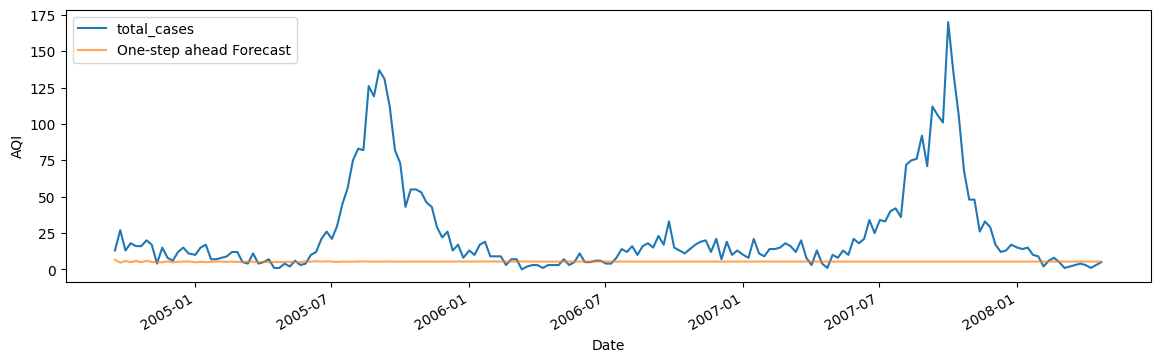

In [71]:
ax = sj_test_labels.plot(label='observed')
SARIMAX_Forecast['SARIMAX_Forecast'].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('AQI')
plt.legend()
plt.show()

In [52]:
y_forecasted2 = SARIMAX_Forecast['SARIMAX_Forecast']
y_forecasted2 = y_forecasted2.values
y_truth2 = sj_test_labels2.values
mse = ((y_forecasted2 - y_truth2) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))

The Mean Squared Error is 1344.04


### IQ

In [53]:
for name, column in iq_train1.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "ndvi_ne" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8361
 No. Lags Chosen       = 52
 Critical value 1%     = -3.448
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.3627. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ndvi_nw" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.3915
 No. Lags Chosen       = 52
 Critical value 1%     = -3.448
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0113. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ndvi_se" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stati

In [54]:
iq_train2 = iq_train1.diff().dropna()

for name, column in iq_train2.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "ndvi_ne" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.8977
 No. Lags Chosen       = 52
 Critical value 1%     = -3.449
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ndvi_nw" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.274
 No. Lags Chosen       = 52
 Critical value 1%     = -3.449
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ndvi_se" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level   

In [55]:
x1 = iq_train2.values
#Standardise dataset
standard_scaler = StandardScaler()
x_scaled1 = standard_scaler.fit_transform(x1)
scaled_data1 = pd.DataFrame(x_scaled1)
scaled_data1.columns = iq_train2.columns

for name, column in scaled_data1.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "ndvi_ne" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.8977
 No. Lags Chosen       = 52
 Critical value 1%     = -3.449
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ndvi_nw" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.274
 No. Lags Chosen       = 52
 Critical value 1%     = -3.449
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ndvi_se" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level   

In [56]:
iq_stepwise_fit1 = pm.auto_arima(iq_train2["total_cases"], start_p=1, start_q=1, max_p=3, max_d=2,max_q=2,m=52,
                             start_P=0,start_Q=0,max_P=3, max_D=2,max_Q=2, seasonal=True, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise
iq_stepwise_fit1.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=2847.480, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2902.989, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2891.885, Time=1.62 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=2868.774, Time=1.06 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2900.989, Time=0.01 sec
 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=2848.057, Time=2.33 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=2848.413, Time=2.18 sec
 ARIMA(1,0,1)(1,0,1)[52] intercept   : AIC=inf, Time=8.11 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=2867.965, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=2892.495, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=2831.248, Time=0.07 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=2832.392, Time=3.26 sec
 ARIMA(2,0,1)(0,0,1)[52] intercept   : AIC=2832.589, Time=2.74 sec
 ARIMA(2,0,1)(1,0,1)[52] intercept   : AIC=inf, Time=4.27 sec
 ARIMA(2,0,0)(0,0,0)[52] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  415
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -1410.175
Date:                Tue, 25 Oct 2022   AIC                           2828.350
Time:                        19:44:55   BIC                           2844.463
Sample:                             0   HQIC                          2834.722
                                - 415                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2795      0.015    -18.651      0.000      -0.309      -0.250
ar.L2         -0.3946      0.012    -32.555      0.000      -0.418      -0.371
ar.L3         -0.1194      0.022     -5.326      0.000      -0.163      -0.075
sigma2        52.3144      1.119     46.761      0.000      50.122      54.507
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              8872.76
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                             1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
iq_test2 = iq_test1.drop(columns=["total_cases"])
iq_test_labels2 = iq_test1["total_cases"]
iq_train3 = iq_train2.drop(columns=["total_cases"])
iq_train_labels2 = iq_train2["total_cases"]

forecast_index = pd.date_range('2008-06-27', '2010-06-25', freq = "W")
driver_forecasts1 = pd.DataFrame(index=forecast_index, columns= iq_test2.columns)
date_index1 = pd.date_range('02-Jul-2000', '24-06-2008',freq="W")
row1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]
row2 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]
date1=datetime.strptime('24-12-2000 0:0:0','%d-%m-%Y %H:%M:%S')
date2=datetime.strptime('25-12-2005 0:0:0','%d-%m-%Y %H:%M:%S')
iq_train3.loc[date1,:] = row1
iq_train3.loc[date2,:] = row2
iq_train3 = iq_train3.sort_index()
iq_train3.index = date_index1

In [58]:
for i in range(len(iq_test2.columns)):
                                            df_series = iq_train3
                                            series_features = pd.Series(df_series.iloc[:,i], index= df_series.index)

                                            stepwise_fit_features = pm.auto_arima(series_features, start_p=2, start_q=1, max_p=3, max_d=2,max_q=3,m=52,
                                                                         start_P=0,start_Q=0,max_P=1,max_D=2,max_Q=3, seasonal=True, trace=True,
                                                                         error_action='ignore',  # don't want to know if an order does not work
                                                                         suppress_warnings=True,  # don't want convergence warnings
                                                                         stepwise=True)  # set to stepwise

                                            SARIMA_Forecast_features = stepwise_fit_features.predict(n_periods= 104)
                                            #Add to driver forecast dataset
                                            driver_forecasts1.iloc[:,i] = SARIMA_Forecast_features

driver_forecasts1.head(5)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=-695.296, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=-767.156, Time=2.44 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=8.32 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=-697.296, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=-768.049, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=-767.169, Time=1.46 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=-765.159, Time=2.36 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=-820.317, Time=0.15 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=-819.439, Time=3.09 sec
 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=-819.467, Time=2.83 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=10.09 sec
 ARIMA(3,0,0)(0,0,0)[52] intercept   : AIC=-853.037, Time=0.30 sec
 ARIMA(3,0,0)(1,0,0)[52] intercept   : AIC=-852.048, Time=6.48 sec
 ARIMA(3,0,0)(0,0,1)[52] intercep

 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=inf, Time=10.00 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=1136.100, Time=2.38 sec
 ARIMA(1,0,1)(1,0,0)[52]             : AIC=1119.540, Time=1.06 sec
 ARIMA(1,0,1)(0,0,0)[52]             : AIC=1128.186, Time=0.08 sec
 ARIMA(1,0,1)(1,0,1)[52]             : AIC=1121.262, Time=2.60 sec
 ARIMA(1,0,1)(0,0,1)[52]             : AIC=1120.586, Time=1.84 sec
 ARIMA(0,0,1)(1,0,0)[52]             : AIC=1122.013, Time=0.66 sec
 ARIMA(1,0,0)(1,0,0)[52]             : AIC=1156.040, Time=0.66 sec
 ARIMA(2,0,1)(1,0,0)[52]             : AIC=inf, Time=6.96 sec
 ARIMA(0,0,0)(1,0,0)[52]             : AIC=1212.648, Time=0.52 sec
 ARIMA(2,0,0)(1,0,0)[52]             : AIC=1134.101, Time=0.92 sec

Best model:  ARIMA(1,0,1)(1,0,0)[52]          
Total fit time: 51.674 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=4385.738, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=4556.657, Time=0.03 sec
 ARIMA(1,0,0)(1,

 ARIMA(1,0,1)(0,0,0)[52]             : AIC=1434.557, Time=0.12 sec
 ARIMA(1,0,1)(1,0,0)[52]             : AIC=1435.204, Time=1.14 sec
 ARIMA(1,0,1)(0,0,1)[52]             : AIC=1435.452, Time=1.43 sec
 ARIMA(1,0,1)(1,0,1)[52]             : AIC=inf, Time=4.21 sec
 ARIMA(0,0,1)(0,0,0)[52]             : AIC=1442.378, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[52]             : AIC=1513.289, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[52]             : AIC=1435.679, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[52]             : AIC=1484.796, Time=0.05 sec

Best model:  ARIMA(1,0,1)(0,0,0)[52]          
Total fit time: 36.611 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=1446.463, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=1363.778, Time=2.00 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=1308.867, Time=2.16 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=1444.465, Time=0.03 sec
 ARIMA(0,0,1)(0,0

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
2008-06-29,0.024719,-0.029080,0.004617,-0.004735,-35.977268,0.064057,-5.809886,-2.944601,0.804782,-0.089176,0.459885,0.861374,1.545045,-24.885265
2008-07-06,0.017291,0.003984,0.011677,0.013898,3.200976,0.107619,0.975531,0.740749,-0.174663,0.091487,0.104345,0.272039,0.036042,4.248029
2008-07-13,-0.015994,0.008956,0.019678,0.000033,1.398448,-0.247959,2.219250,2.857900,-0.990266,-0.024387,0.023675,0.229339,0.120140,-3.019101
2008-07-20,-0.005352,0.006836,-0.012146,0.005733,0.301663,0.296395,-2.336582,-2.414008,1.149144,0.090272,0.005372,0.215510,-0.024028,-1.064426
2008-07-27,0.006630,-0.004781,0.012647,0.007087,8.001508,-0.171519,1.161586,-0.152041,-0.252244,-0.342938,0.001219,0.137131,-0.516602,4.257706


In [59]:
# fitting a stepwise model to find the best paramters for SARIMAX:
iq_stepwise_fit2 = pm.auto_arima(iq_train_labels2, start_p=1, start_q=1, max_p=3, max_d=2,max_q=2,m=52,
                             start_P=0,start_Q=0,max_P=3, max_D=2,max_Q=2, seasonal=True, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

iq_stepwise_fit2.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=2847.480, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2902.989, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2891.885, Time=2.79 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=2868.774, Time=2.32 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2900.989, Time=0.02 sec
 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=2848.057, Time=3.82 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=2848.413, Time=3.00 sec
 ARIMA(1,0,1)(1,0,1)[52] intercept   : AIC=inf, Time=10.32 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=2867.965, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=2892.495, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=2831.248, Time=0.17 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=2832.392, Time=4.61 sec
 ARIMA(2,0,1)(0,0,1)[52] intercept   : AIC=2832.589, Time=4.18 sec
 ARIMA(2,0,1)(1,0,1)[52] intercept   : AIC=inf, Time=6.39 sec
 ARIMA(2,0,0)(0,0,0)[52] int

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  415
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -1410.175
Date:                Tue, 25 Oct 2022   AIC                           2828.350
Time:                        20:01:14   BIC                           2844.463
Sample:                             0   HQIC                          2834.722
                                - 415                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2795      0.015    -18.651      0.000      -0.309      -0.250
ar.L2         -0.3946      0.012    -32.555      0.000      -0.418      -0.371
ar.L3         -0.1194      0.022     -5.326      0.000      -0.163      -0.075
sigma2        52.3144      1.119     46.761      0.000      50.122      54.507
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              8872.76
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                             1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
# SARIMAX 
# contrived dataset
iq_train3=iq_train3.drop("24-12-2000")
iq_train3=iq_train3.drop("25-12-2005")
row3 = [0]
row4 = [0]
date3=datetime.strptime('24-12-2000','%d-%m-%Y')
date4=datetime.strptime('25-12-2005','%d-%m-%Y')
iq_train_labels2.at['24-12-2000']='0'
iq_train_labels2.at['25-12-2005']='0'

iq_train_labels2 = iq_train_labels2.sort_index()
iq_train_labels2.index = date_index1
data1 = iq_train_labels2
data1=data1.drop("24-12-2000")
data1=data1.drop("25-12-2005")

KeyError: "['24-12-2000'] not found in axis"

In [61]:
data2 = iq_train3
data1 = data1.astype(np.float64)
data2 = data2.astype(np.float64)
data3 = np.array(data1)
data3 = data3.astype(np.float64)
data4 = np.array(data2)
data4 = data4.astype(np.float64)
data5 = np.nan_to_num(driver_forecasts1)
data5 = data5.astype(np.float64)
Latest_target = iq_test_labels.tail(1).values.tolist()

In [66]:
# fit model
model = SARIMAX(data1, exog=data2, order=(3,0,0), seasonal_order=(0,0,0,52))
model_fit = model.fit(disp=False)
# make prediction
exog2 = data5
SARIMAX_Forecast = pd.DataFrame(model_fit.predict(len(data1),len(data1)+103, exog=exog2))
SARIMAX_Forecast.columns = ['Raw_Forecast']
SARIMAX_Forecast['SARIMAX_Forecast_De_Standardise_R_Sum'] = SARIMAX_Forecast['Raw_Forecast'].cumsum()
SARIMAX_Forecast['SARIMAX_Forecast'] = SARIMAX_Forecast['SARIMAX_Forecast_De_Standardise_R_Sum'] + Latest_target[0]

SARIMAX_Forecast.index = iq_test_labels.index
print(SARIMAX_Forecast)
any (n<0 for n in SARIMAX_Forecast['SARIMAX_Forecast'])

                 Raw_Forecast  SARIMAX_Forecast_De_Standardise_R_Sum  \
week_start_date                                                        
2008-07-01           0.332164                               0.332164   
2008-07-08          -0.216416                               0.115748   
2008-07-15           0.282482                               0.398231   
2008-07-22          -0.086529                               0.311702   
2008-07-29           0.334051                               0.645752   
...                       ...                                    ...   
2010-05-28           0.006101                               0.582957   
2010-06-04          -0.007396                               0.575561   
2010-06-11          -0.010623                               0.564938   
2010-06-18           0.008870                               0.573808   
2010-06-25          -0.005167                               0.568641   

                 SARIMAX_Forecast  
week_start_date            

False

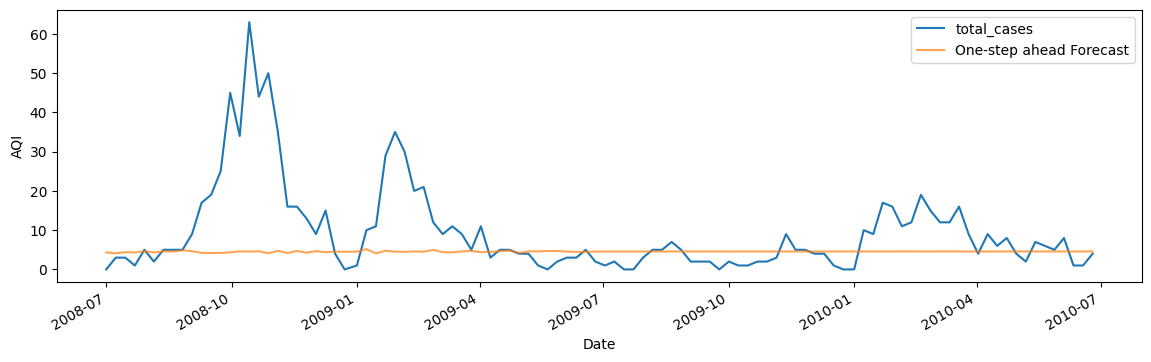

In [63]:
ax = iq_test_labels.plot(label='observed')
SARIMAX_Forecast['SARIMAX_Forecast'].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('AQI')
plt.legend()
plt.show()

In [64]:
y_forecasted3 = SARIMAX_Forecast['SARIMAX_Forecast']
y_forecasted3 = y_forecasted3.values
y_truth3 = iq_test_labels2.values
mse = ((y_forecasted3 - y_truth3) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))

The Mean Squared Error is 155.75
